Author: Shiyu Chen

Gitlab: https://github.com/13RENDA/ECE399-HW6.git

In [7]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/EE399Lab6/pyshred')
import numpy as np
from processdata import load_data, TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from processdata import load_full_SST

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Define training function

def training(num_sensors,lags,load_X,n,m,sensor_locations):
  train_indices = np.random.choice(n - lags, size=1000, replace=False)
  mask = np.ones(n - lags)
  mask[train_indices] = 0
  valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
  valid_indices = valid_test_indices[::2]
  test_indices = valid_test_indices[1::2]

  sc = MinMaxScaler()
  sc = sc.fit(load_X[train_indices])
  transformed_X = sc.transform(load_X)

  ### Generate input sequences to a SHRED model
  all_data_in = np.zeros((n - lags, lags, num_sensors))
  for i in range(len(all_data_in)):
      all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

  ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
  valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
  test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

  ### -1 to have output be at the same time as final sensor measurements
  train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
  valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
  test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

  train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
  valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
  test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

  shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
  # validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

  test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
  test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
  # print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

  # SST data with world map indices for plotting
  full_SST, sst_locs = load_full_SST()
  full_test_truth = full_SST[test_indices, :]

  # replacing SST data with our reconstruction
  full_test_recon = full_test_truth.copy()
  full_test_recon[:,sst_locs] = test_recons

  # reshaping to 2d frames
  for x in [full_test_truth, full_test_recon]:
      x.resize(len(x),180,360)

  plotdata = [full_test_truth, full_test_recon]
  mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
  labels = ['truth','recon']
  fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
  for axis,p,label in zip(ax, plotdata, labels):
      axis.imshow(p[0])
      axis.set_aspect('equal')
      axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)
  return mse

### 1. Make a plot to the training data

Test Error: 0.2197908


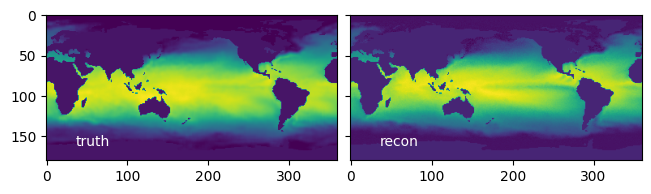

In [ ]:
# Make the plot
error1 = training(num_sensors,lags,load_X,n,m,sensor_locations)
print ("Test Error:", error1)

In [15]:
# Define training function

def training2(num_sensors,lags,load_X,n,m,sensor_locations):
  train_indices = np.random.choice(n - lags, size=1000, replace=False)
  mask = np.ones(n - lags)
  mask[train_indices] = 0
  valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
  valid_indices = valid_test_indices[::2]
  test_indices = valid_test_indices[1::2]

  sc = MinMaxScaler()
  sc = sc.fit(load_X[train_indices])
  transformed_X = sc.transform(load_X)

  ### Generate input sequences to a SHRED model
  all_data_in = np.zeros((n - lags, lags, num_sensors))
  for i in range(len(all_data_in)):
      all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

  ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
  valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
  test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

  ### -1 to have output be at the same time as final sensor measurements
  train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
  valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
  test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

  train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
  valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
  test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

  shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
  # validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

  test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
  test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
  # print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

  # SST data with world map indices for plotting
  full_SST, sst_locs = load_full_SST()
  full_test_truth = full_SST[test_indices, :]

  # replacing SST data with our reconstruction
  full_test_recon = full_test_truth.copy()
  full_test_recon[:,sst_locs] = test_recons

  mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
 
  print ("Test Error:", mse)
  return mse

### 2. Change time lag


Test Error: 0.21666826
Test Error: 0.21872525
Test Error: 0.21776472
Test Error: 0.21693513
Test Error: 0.2184445
Test Error: 0.21846923
Test Error: 0.21500938
Test Error: 0.21858785
Test Error: 0.21617262
Test Error: 0.21737465


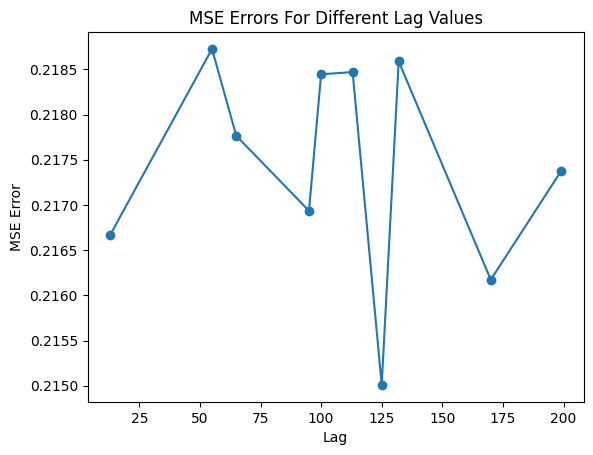

In [ ]:
# Define the list of lag values
lag_val = [13, 55, 65, 95, 100, 113, 125, 132, 170, 199]
num_sensors = 3 
mse_errors = []

for lag in lag_val:
    mse = training2(num_sensors,lags,load_X,n,m,sensor_locations)
    mse_errors.append(mse)
    

# Plot MSE errors vs lags
plt.figure()
plt.plot(lag_val, mse_errors, marker='o')
plt.xlabel("Lag")
plt.ylabel("MSE Error")
plt.title("MSE Errors For Different Lag Values")
plt.show()

### Change number of sensors

Test Error: 0.2175435
Test Error: 0.21776855
Test Error: 0.22134314
Test Error: 0.21992476
Test Error: 0.21890831
Test Error: 0.21852712
Test Error: 0.21891499
Test Error: 0.2185888
Test Error: 0.21746394
Test Error: 0.21774714


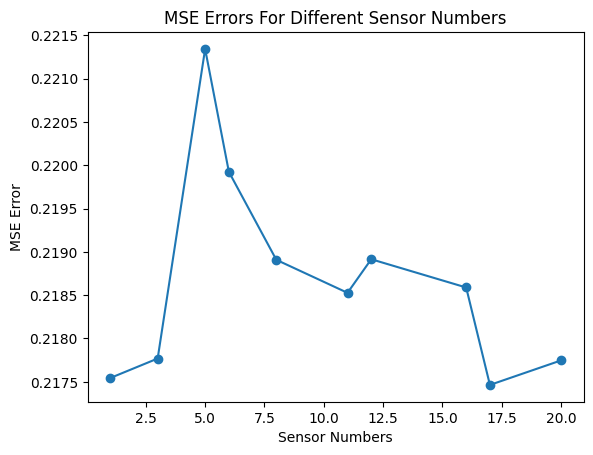

In [ ]:

sensor_num = [1, 3, 5, 6, 8, 11, 12, 16, 17, 20]
lag = 52
mse_errors = []

for num_sensors in sensor_num:
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
    mse = training2(num_sensors,lag,load_X,n,m,sensor_locations)
    mse_errors.append(mse)

# Plot MSE errors vs sensor numbers
plt.figure()
plt.plot(sensor_num, mse_errors, marker='o')
plt.xlabel("Sensor Numbers")
plt.ylabel("MSE Error")
plt.title("MSE Errors For Different Sensor Numbers")
plt.show()


### Add noise to data

In [ ]:
# Parameters for Gaussian noise
mean = 0  # Mean of the Gaussian distribution
num_sensors = 3
lags = 52
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Add Gaussian noise to data
noise_std = np.linspace(0, 0.5, num=10)
errors = []
for std in noise_std:
  load_X_noise = load_X + np.random.normal(mean, std, size=load_X.shape)
  e = training2(num_sensors,lags,load_X_noise,n,m,sensor_locations)
  errors.append(e)

# Plotting the test error as a function of noise
plt.plot(noise_std, errors)
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Test Error')
plt.title('Test Error as a Function of Noise')
plt.grid(True)
plt.show()
#Train with noisy data
training(num_sensors,lags,load_X_noise,n,m,sensor_locations)

Test Error: 0.2180565
